In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
import glob
from copy import deepcopy

import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
import equinox as eqx

In [4]:
from mc2.utils.data_inspection import (
    get_available_material_names,
    get_file_overview,
    load_and_process_single_from_full_file_overview
)
from mc2.data_management import FrequencySet, MaterialSet, DataSet

## load data from pickle:

In [5]:
LOAD_ALL_MATERIALS = False
SAVE_SINGLE_PICKLE = False

if LOAD_ALL_MATERIALS:
    dataset = DataSet.load_from_file(pathlib.Path("../../data/processed") / "ten_mat_data.pickle")

    # deleting N49 from dataset for now, since the data is incomplete
    # 50 kHz and 80 kHz are missing
    # 320 kHz has no data at 25 degrees

    available_materials = deepcopy(dataset.material_names)
    print(available_materials)
    print(len(available_materials))

    available_materials.remove("N49")
    print(available_materials)
    print(len(available_materials))
  
    if SAVE_SINGLE_PICKLE:
        dataset_3C90 = dataset.filter_materials(['3C90'])
        dataset_3C90.save_to_file(pathlib.Path("../../data/processed") / "3C90.pickle")  

In [6]:
LOAD_3C90 = True
dataset = DataSet.load_from_file(pathlib.Path("../../data/processed") / "3C90.pickle")

INFO:2025-08-06 17:08:45,584:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


2025-08-06 17:08:45 | INFO : Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


INFO:2025-08-06 17:08:45,588:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-08-06 17:08:45 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [7]:
# Filter from full dataset for a single material and temperature
data_3C90 = dataset.filter_materials(material_names="3C90")
data_3C90_25_C = data_3C90.filter_temperatures([25])

print("Frequencies:")
for frequency_set in data_3C90_25_C.material_sets[0].frequency_sets:
    print(frequency_set.frequency)

Frequencies:
50000.0
80000.0
125000.0
200000.0
320000.0
500000.0
800000.0


In [8]:
# def find_peaks_jax(x, height=None):
#     left = jnp.roll(x, 1)
#     right = jnp.roll(x, -1)

#     peaks = (x > left) & (x > right)
#     peaks = peaks.at[0].set(False)
#     peaks = peaks.at[-1].set(False)

#     if height is not None:
#         peaks &= x >= height

#     return jnp.where(peaks)[0], None

# def get_frequency(signal, fs):
#     max_abs_val = jnp.max(jnp.abs(signal))
#     min_peak_height = 0.8 * max_abs_val
#     pos_idx, _ = find_peaks_jax(signal, height=min_peak_height)  # find_peaks(signal,height=min_peak_height)
#     pos_intervals = jnp.diff(pos_idx) / fs
#     neg_idx, _ = find_peaks_jax(-signal, height=min_peak_height)
#     neg_intervals = jnp.diff(neg_idx) / fs

#     mean_interval_neg = jnp.median(neg_intervals)
#     mean_interval_pos = jnp.median(pos_intervals)
#     mean_interval = jax.lax.cond(
#         jnp.var(pos_intervals) < jnp.var(neg_intervals),
#         lambda _: mean_interval_pos,
#         lambda _: mean_interval_neg,
#         operand=None,
#     )
#     frequency = 1.0 / mean_interval
#     return frequency

In [13]:
def find_peaks_jax(x, height=None):
    left = jnp.roll(x, 1)
    right = jnp.roll(x, -1)

    peaks = (x > left) & (x > right)
    peaks = peaks.at[0].set(False)
    peaks = peaks.at[-1].set(False)

    if height is not None:
        peaks &= x >= height

    max_peaks = x.shape[0] 
    idx = jnp.where(peaks, size=max_peaks, fill_value=-1)[0]

    return idx, None

def compute_intervals(idx, fs):
    valid_mask = idx >= 0
    idx_filled = jnp.where(valid_mask, idx, 0)
    valid_intervals_mask = valid_mask[1:] & valid_mask[:-1]
    intervals = jnp.diff(idx_filled) / fs
    intervals = jnp.where(valid_intervals_mask, intervals, jnp.nan)
    return intervals

def get_frequency(signal, fs):
    min_peak_height_pos = 0.8 * jnp.max(signal)
    min_peak_height_neg = 0.8 * jnp.max(-signal) 

    pos_idx, _ = find_peaks_jax(signal, height=min_peak_height_pos)
    neg_idx, _ = find_peaks_jax(-signal, height=min_peak_height_neg)
    
    pos_intervals = compute_intervals(pos_idx, fs)
    neg_intervals = compute_intervals(neg_idx, fs)
    
    mean_interval_pos = jnp.nanmedian(pos_intervals)
    mean_interval_neg = jnp.nanmedian(neg_intervals)
    
    mean_interval = jax.lax.cond(
        jnp.nanvar(pos_intervals) < jnp.nanvar(neg_intervals),
        lambda _: mean_interval_pos,
        lambda _: mean_interval_neg,
        operand=None,
    )
    
    frequency = 1.0 / mean_interval
    return frequency

### Analysis of the magnetic flux density input data
#### Features:
- Dynamic average of the magnetic flux density (b_avg) represents the "slow premagnetisation"
- First derivative of the magnetic flux density (db/dt) represents the switched voltage (which is the non-idealized input trigger)
- Second derivative of the magnetic flux density (d2b/dt2) represents the switched voltage slew rate (switching transients, but no oscillations visible, unlike in MC1)
- PWM signal (pwm) represents the idealized input trigger
- Dynamic duty cycle (d_avg) represents the (ideal) control signal

50000.0


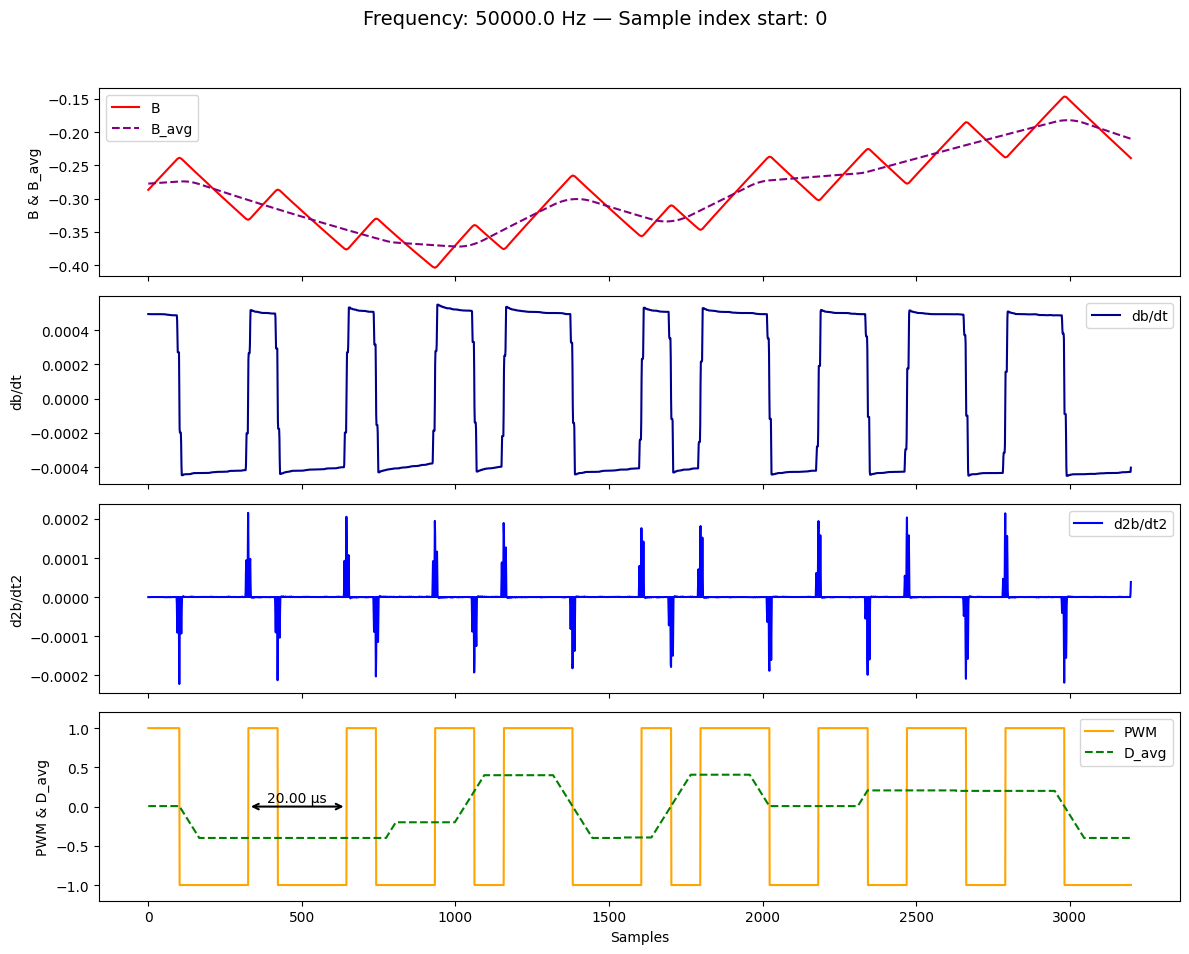

80402.01


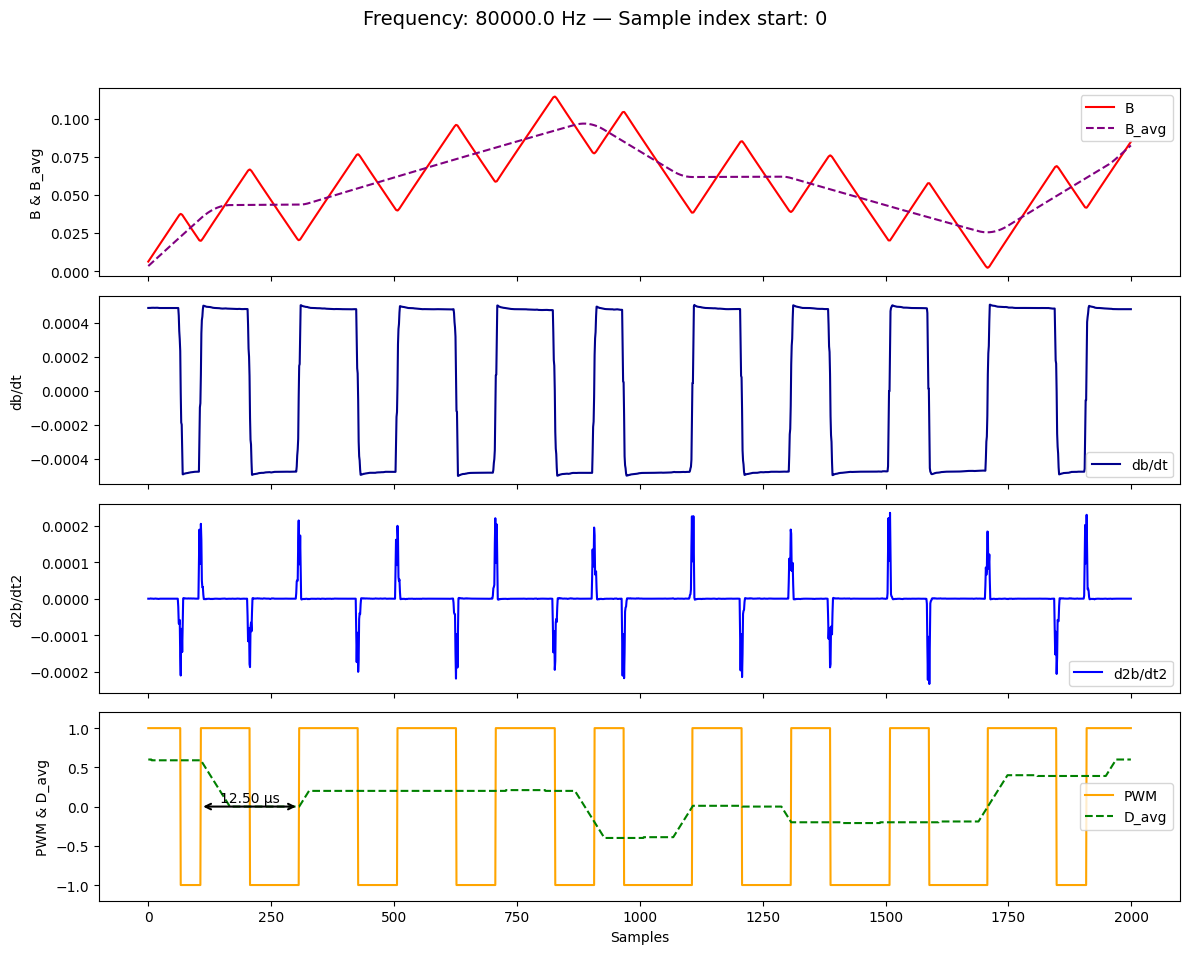

125000.0


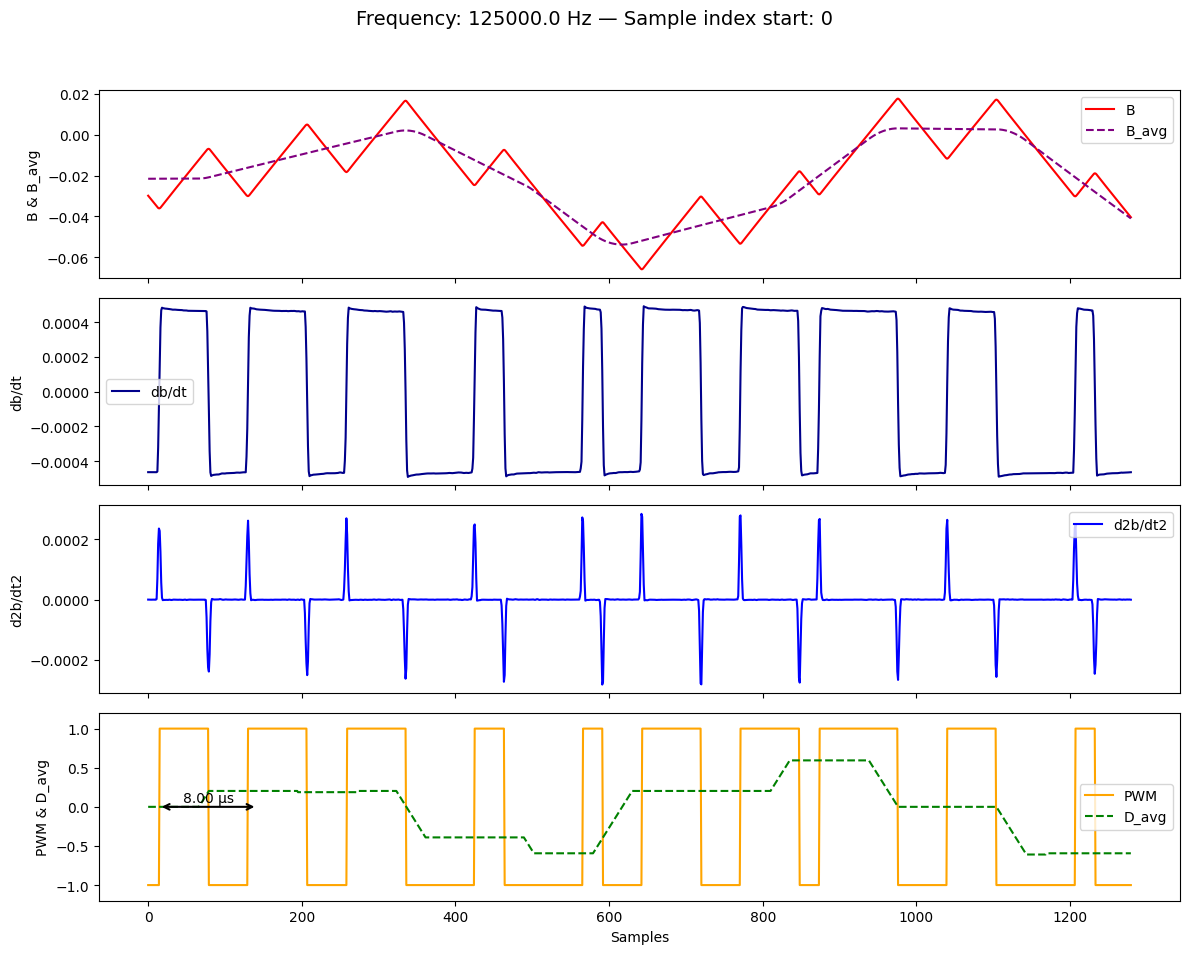

125000.0


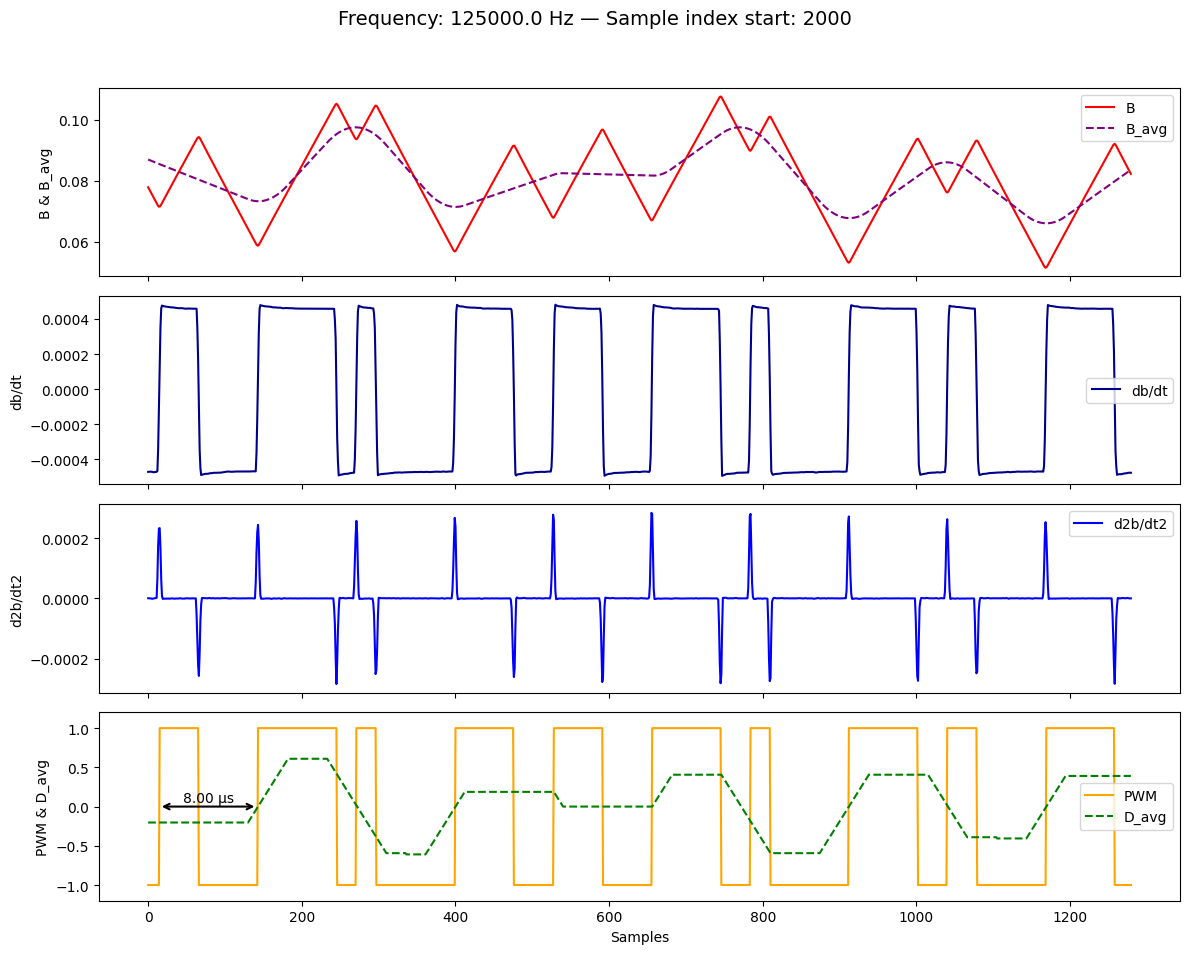

200000.0


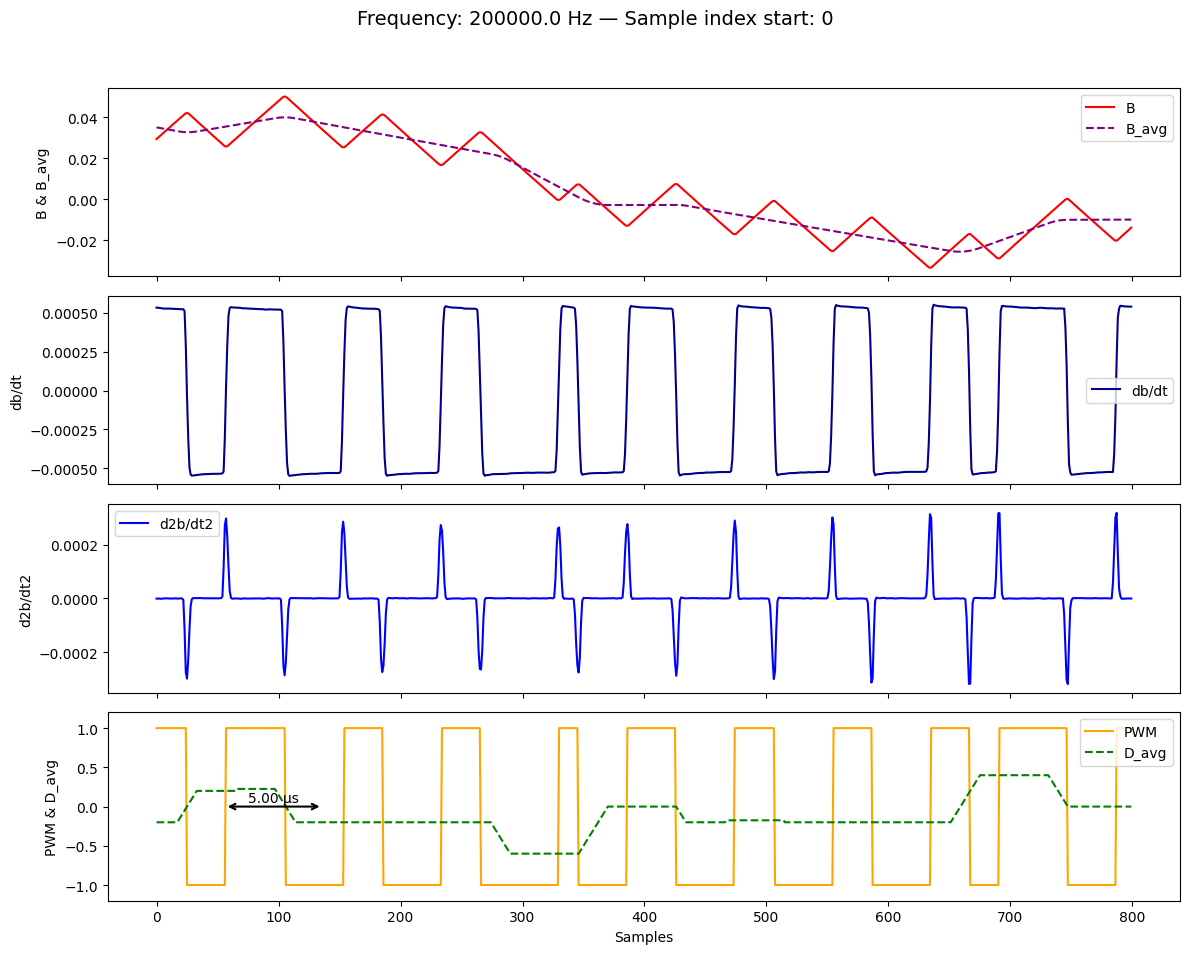

200000.0


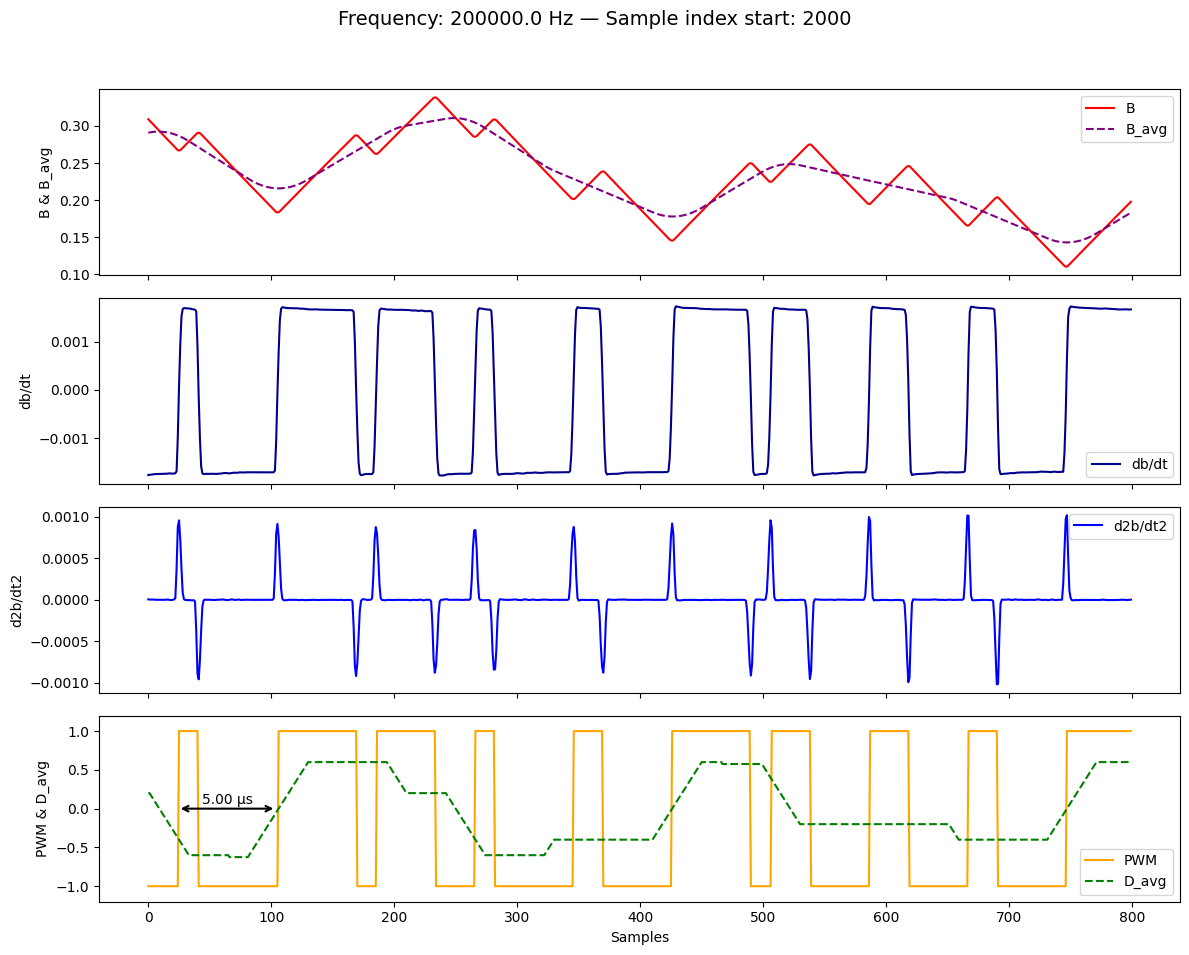

320000.0


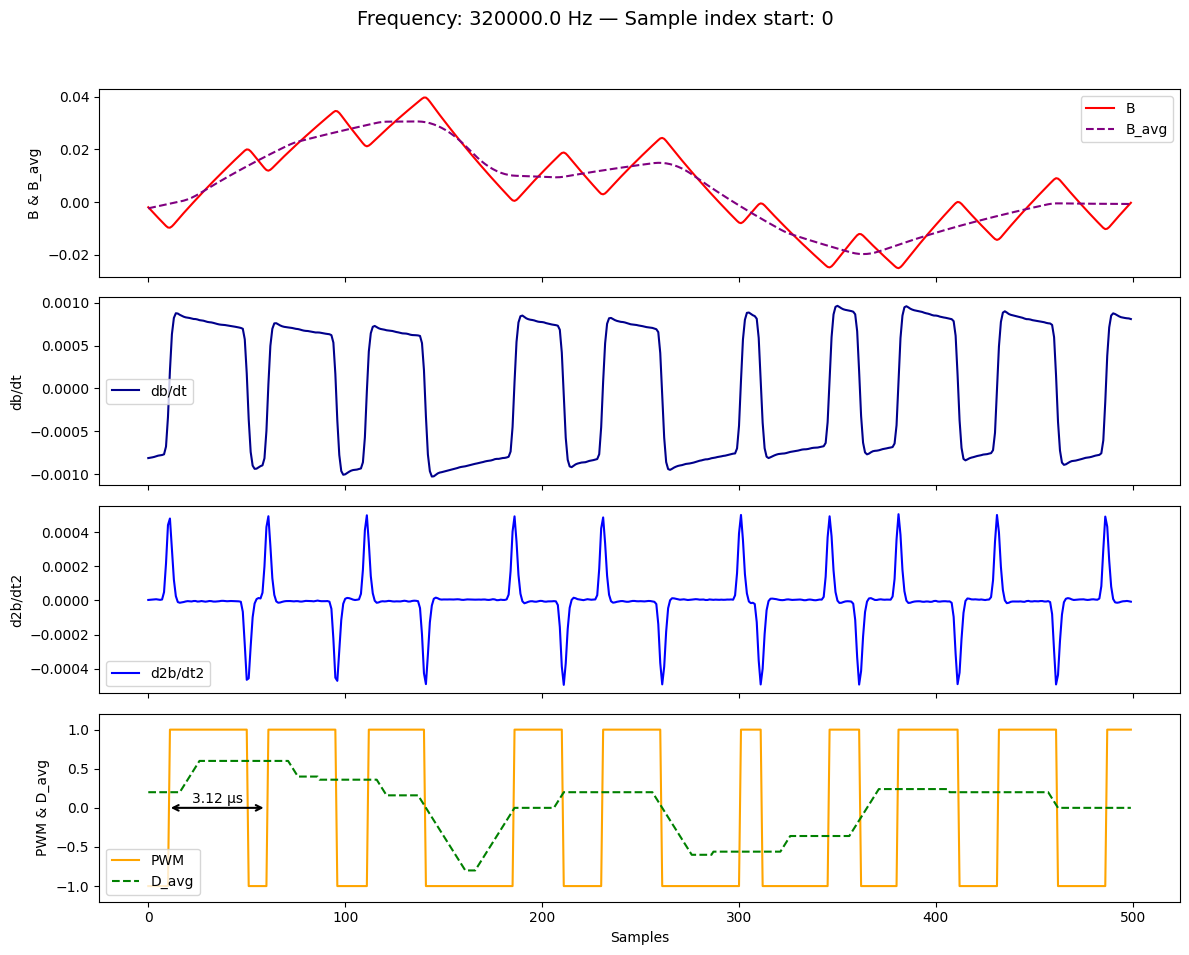

320000.0


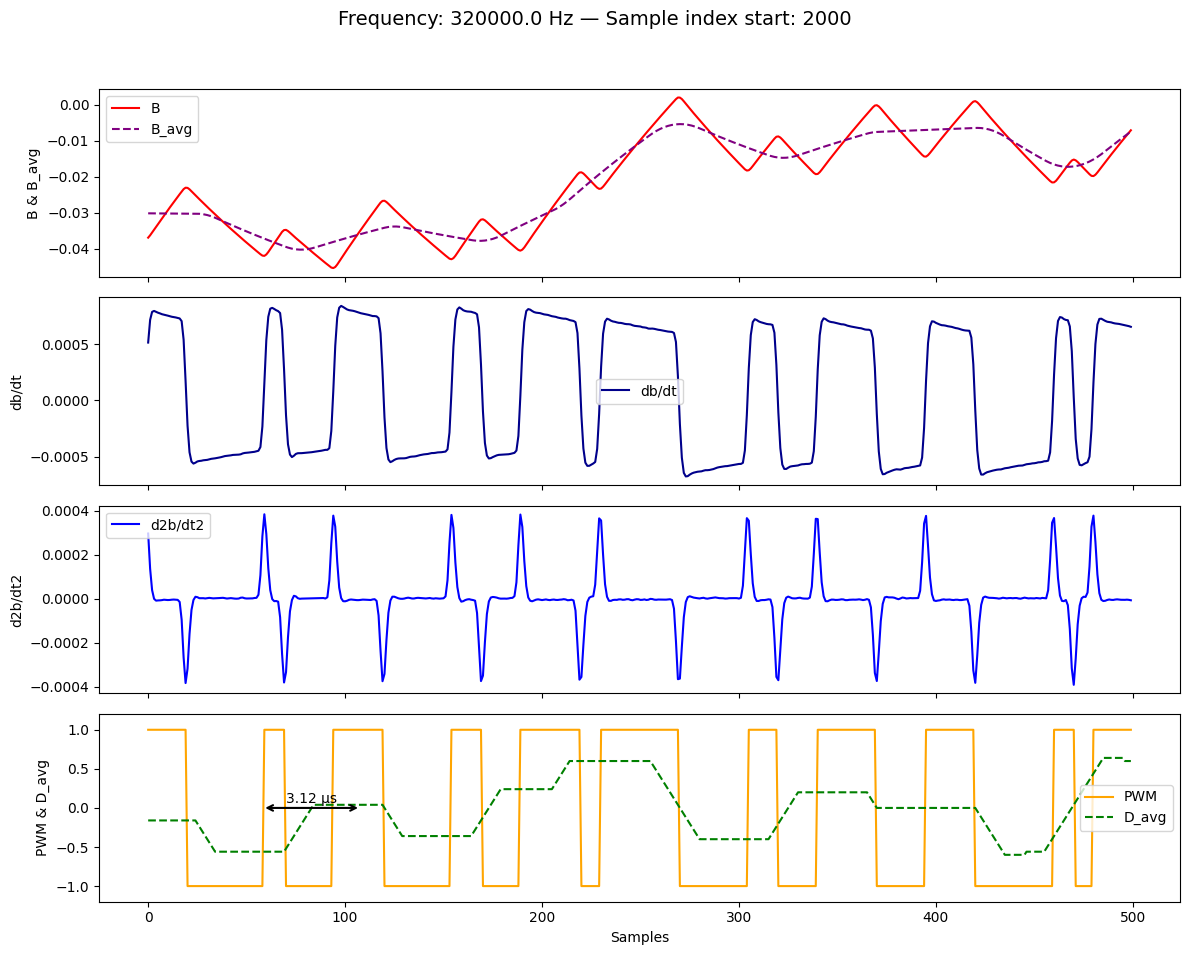

500000.0


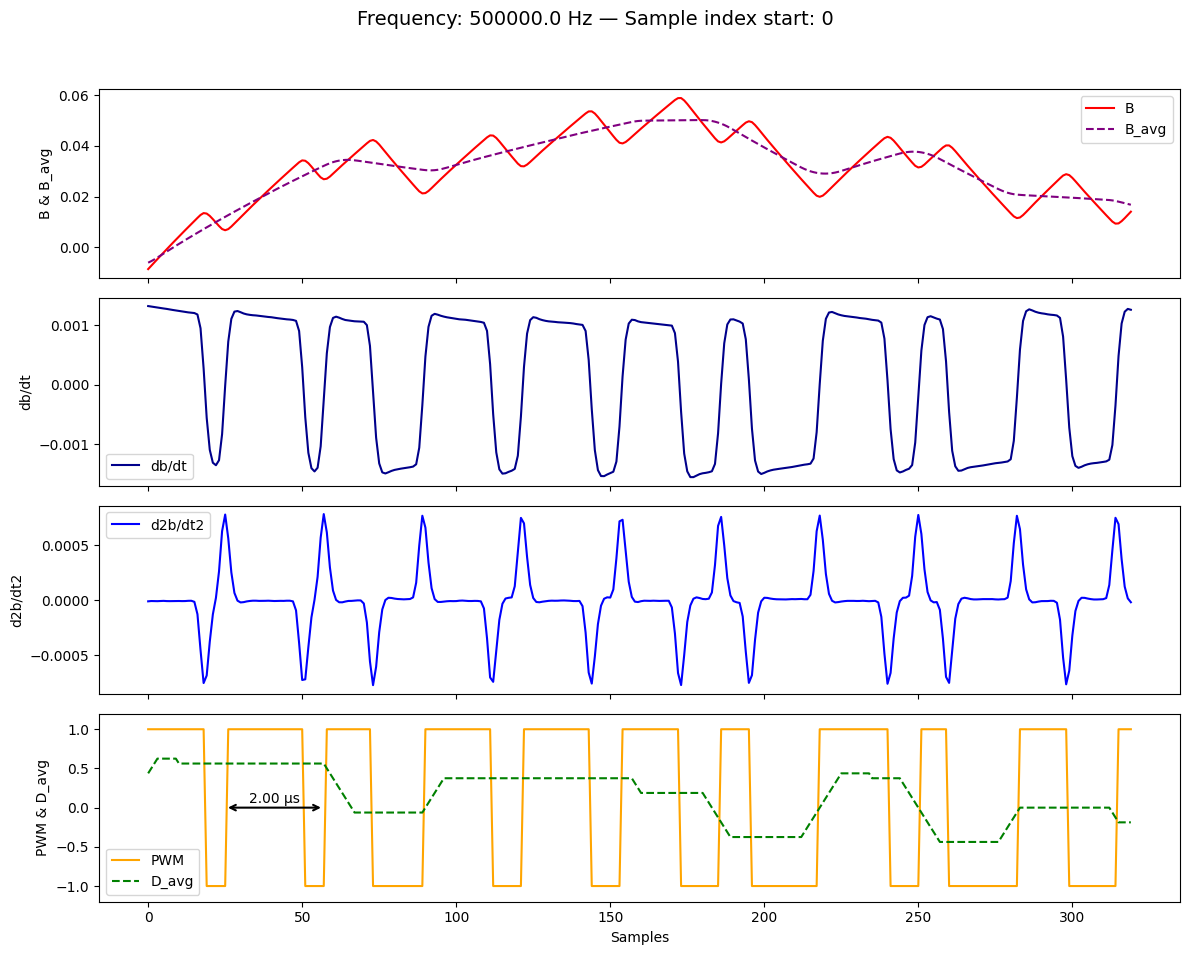

500000.0


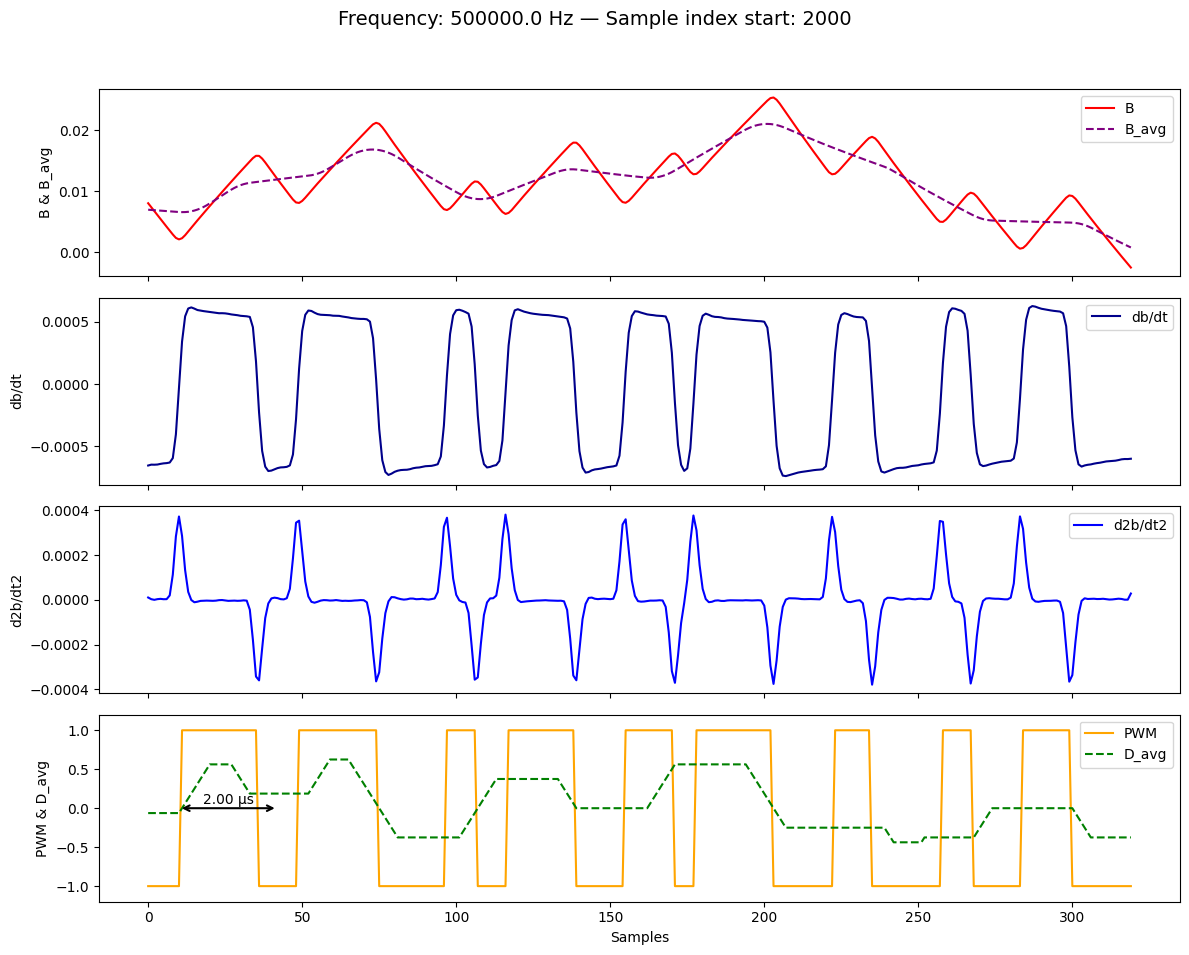

800000.0


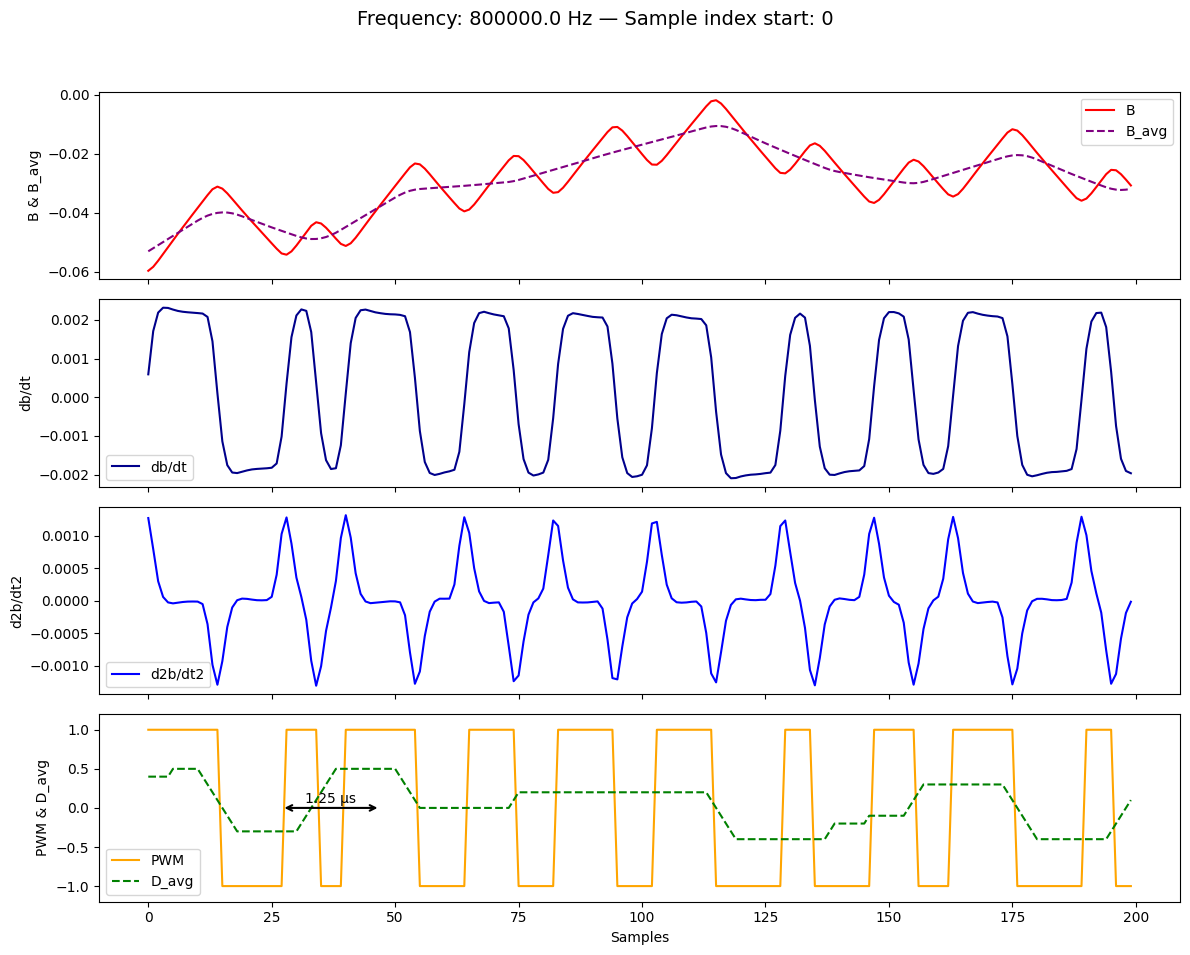

800000.0


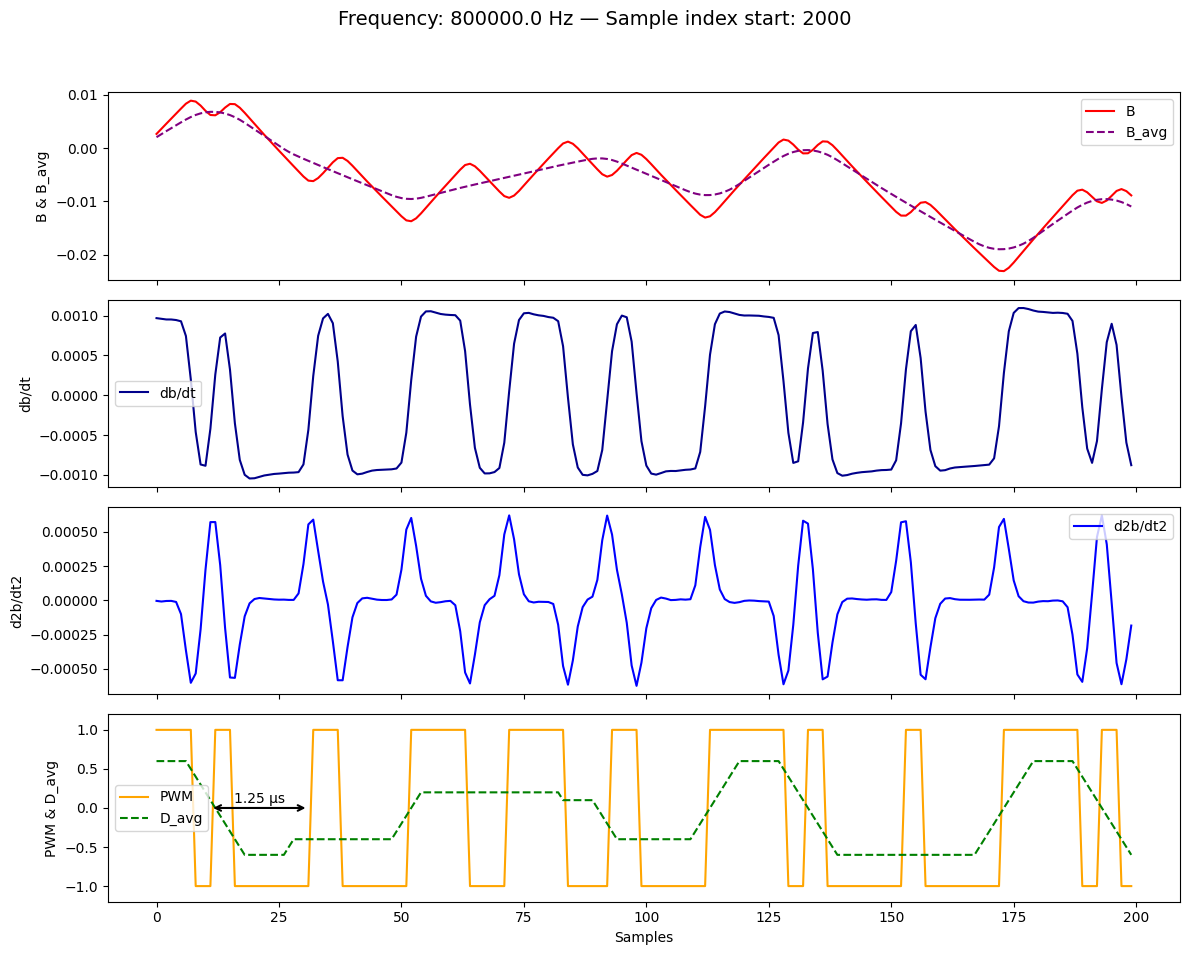

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mc2.features.features import dyn_avg, db_dt, d2b_dt2, pwm_of_b

# Constants
f_sample = 16e6  # 16 MHz
start_sample = 1000
n_periodes = 10

for frequency_set in data_3C90.material_sets[0].frequency_sets: #
    frequency = frequency_set.frequency
    n_s = int(f_sample / frequency)
    end_point = n_s * n_periodes
    T_sw_us = 1e6 / frequency  # in µs

    for i in range(0, frequency_set.H.shape[0], 2000):
        h = frequency_set.H[i]
        b = frequency_set.B[i]
        dbdt = db_dt(b)
        d2bdt = d2b_dt2(b)
        print(get_frequency(d2bdt, f_sample))
        #PWM between -1 and +1
        pwm = pwm_of_b(b)
        
        # Dynamic average of b
        # b_avg = np.convolve(b, np.ones(n_s) / n_s, mode='same')
        b_avg = dyn_avg(b, n_s)

        
        # Dynamically averaged duty cycle in [-1, +1]
        d_avg = dyn_avg(pwm, n_s)

        start_idx = start_sample
        end_idx = start_sample + end_point
        pwm_slice = pwm[start_idx:end_idx]


        fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f'Frequency: {frequency:.1f} Hz — Sample index start: {i}', fontsize=14)

        axs[0].plot(b[start_idx:end_idx], label='B', color='red')
        axs[0].plot(b_avg[start_idx:end_idx], label='B_avg', color='purple', linestyle='--')
        axs[0].legend()
        axs[0].set_ylabel('B & B_avg')

        axs[1].plot(dbdt[start_idx:end_idx], label='db/dt', color='darkblue')
        axs[1].legend()
        axs[1].set_ylabel('db/dt')

        axs[2].plot(d2bdt[start_idx:end_idx], label='d2b/dt2', color='blue')
        axs[2].legend()
        axs[2].set_ylabel('d2b/dt2')

        axs[3].plot(pwm_slice, label='PWM', color='orange')
        axs[3].plot(d_avg[start_idx:end_idx], label='D_avg', color='green', linestyle='--')
        axs[3].legend()
        axs[3].set_ylabel('PWM & D_avg')
        axs[3].set_xlabel('Samples')
        axs[3].set_ylim(-1.2, 1.2)


        # Draw sw. periode 
        rising_edges = np.where(np.diff(pwm_slice) == 2)[0]  # since pwm is now ±1, rising edge is  -1→+1 difference = 2
        if len(rising_edges) == 0:
            continue

        local_edge = rising_edges[0]
        arrow_start = local_edge
        arrow_end = arrow_start + n_s

        y_arrow = 0
        axs[3].annotate(
            '',
            xy=(arrow_end, y_arrow),
            xytext=(arrow_start, y_arrow),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1.5)
        )
        axs[3].text(
            (arrow_start + arrow_end) / 2,
            y_arrow + 0.02,
            f"{T_sw_us:.2f} µs",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


# Code colletion:

In [ ]:
from scipy.optimize import curve_fit
# Find out, 
# ...Neukurve extrahieren:
# Ansatz: einen geeigneten curve fit finden
f_sample = 16e6 # 16 MHz

def new_curve(fb, alpha, beta, k):
    return np.atanh()

# Plot the dutycycle (over time)
for frequency_set in data_3C90_25_C.material_sets[0].frequency_sets:
    # print(frequency_set.H.shape[0])
    for i in range(0, frequency_set.H.shape[0], 2000):

        # A single "PFC" sequence:
        h, b, f = frequency_set.H[i], frequency_set.B[i], frequency_set.frequency
        dbdt = np.gradient(b)
        sign = np.sign(dbdt)

        sign_changes = np.diff(sign, append=sign[0])  # append the first value to keep the same dimension

        # Samples per periode:
        n_s = int(f_sample / f)
        
        pwm = (sign[0:5000] + 1) / 2 
        d_avg = np.convolve(pwm, np.ones(n_s)/n_s, mode='same')
        # d_avg = np.convolve(pwm, np.ones(n_s), mode='same')
        # plt.plot(dbdt)
        # plt.plot(pwm)
        # plt.plot(sign_changes[0:5000])
        # plt.plot(d_avg)
        # h_avg = np.convolve(h, np.ones(n_s)/n_s, mode='same')
        # b_avg = np.convolve(b, np.ones(n_s)/n_s, mode='same')
        # plt.plot(h_avg, b_avg)
        plt.plot(h, b)


popt_SE, pcov_SE = curve_fit(new_curve, (df_T["f"], df_T["b"]), np.log(df_T["pv"]))

    
plt.show()

In [ ]:
# Plots of where the switching events occur
# Counting of the withing events


PLOT_HYSTERESIS = True
PLOT_SWITCHING_EVENTS = True
PLOT_RIPPLE_HIST = False

for frequency_set in data_3C90_25_C.material_sets[0].frequency_sets:
    print(frequency_set)
    for i in range(0, frequency_set.H.shape[0], 100):
        h, b, f = frequency_set.H[i], frequency_set.B[i], frequency_set.frequency
        if PLOT_HYSTERESIS:
            plt.plot(h, b)

        # postive, if db/dt is positive and 
        bool_ascending = np.roll(b, shift=1) - b
        # Get the sign of each element
        signs = np.sign(bool_ascending)
        # Compute differences between adjacent signs
        sign_changes = np.diff(signs, append=signs[0])  # append the first value to keep the same dimension


        # Count non-zero sign changes
        # always 198 ...
        count_sign_changes = np.count_nonzero(sign_changes)
        print("\nSign changes of db/dt:")
        print(f"No. of 1: {count_sign_changes} (sign changes)")
        print(f"No. of 0: {len(sign_changes)-count_sign_changes}\n")


        # Carrier signal with "slow" frequency
        print("Carrier signal:")
        T_carrier = 1 / f * count_sign_changes / 2
        print(f"{T_carrier = }")
        f_carrier = 1 / T_carrier
        print(f"{f_carrier = }")
        print(f"hmax = {float(max(h))}")
        print(f"bmax = {float(max(b))}\n")


        # Find the amplitude:
        mask = (sign_changes != 0).astype(int)  # this is 1, if there is the beginning or the end of a "fast" cycle

        b_HF_amplitudes = np.where(mask, b, 0)

        b_HF_amplitudes_filtered = b_HF_amplitudes[b_HF_amplitudes != 0]
        b_ripple = abs(np.roll(b_HF_amplitudes_filtered, shift=-1) - b_HF_amplitudes_filtered)


        if PLOT_RIPPLE_HIST:
            # Overimposed "fast" ripple
            print("Overimposed ripple:")
            plt.hist(b_ripple)

        if PLOT_SWITCHING_EVENTS:
            plt.plot(h, mask/10, label="switching events") # db/dt sign changes 

        plt.legend()
        plt.show()